Para correr esto es importante tener bien configurado el archivo hyperparameters, los análisis son en su mayoría sobre el perceptron descripto ahí. 

ej:

# ej2_analysis.json

```json
{
    "epochs": 10000,
    "learning_rate": 0.001,
    "epsilon": 1e-5,
    "non_linear_fn": "tanh",
    "beta": 2.0,
    "seed": 42
}
```

- Para ver el ultimo grafico usar sigmoid con algún beta menor a 1 y 1000 o más iteraciones
- Para todo lo demás usar tanh 2.0 con n epochs

```json
{
    "epochs": 1000,
    "learning_rate": 0.001,
    "epsilon": 1e-5,
    "non_linear_fn": "sigmoid",
    "beta": 0.5,
    "seed": 42
}
```

In [48]:
import numpy as np
import sys
import json
from models.perceptrons.perceptron_linear import PerceptronLinear
from models.perceptrons.perceptron_non_linear import PerceptronNonLinear
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


leer y guardar x, y

In [49]:
config_file_path = "../config/ej2_analysis.json"
with open(config_file_path, 'r') as file:
    config_file = json.load(file)


# Load the dataset
df = pd.read_csv("../res/TP3-ej2-conjunto.csv")

print("Read dataset")

# Split the DataFrame into X and y
X = df[['x1', 'x2', 'x3']].values
y = df['y'].values


Read dataset


In [50]:
# Para el non-linear hay que normalizar los datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# Scale inputs for sigmoid (0 to 1)
scaler_X_sigmoid = MinMaxScaler(feature_range=(0, 1))
X_scaled_logistic = scaler_X_sigmoid.fit_transform(X)  # scaled for sigmoid

# Scale inputs for tanh (-1 to 1)
scaler_X_tanh = MinMaxScaler(feature_range=(-1, 1))
X_scaled_tanh = scaler_X_tanh.fit_transform(X)  # scaled for tanh

# Scale outputs for sigmoid (0 to 1)
scaler_y_sigmoid = MinMaxScaler(feature_range=(0, 1))
y_scaled_logistic = scaler_y_sigmoid.fit_transform(y.reshape(-1, 1)).ravel()  # scaled for sigmoid

# Scale outputs for tanh (-1 to 1)
scaler_y_tanh = MinMaxScaler(feature_range=(-1, 1))
y_scaled_tanh = scaler_y_tanh.fit_transform(y.reshape(-1, 1)).ravel()

In [51]:

# Initialize Perceptrons
learning_rate = config_file.get('learning_rate', 0.01)
epsilon = config_file.get('epsilon', 1e-5)
seed = config_file.get('seed', 0)
non_linear_fn = config_file.get('non_linear_fn', 'sigmoid')
beta = config_file.get('beta', 0.9)

perceptron_linear = PerceptronLinear(
    seed=config_file.get('seed', 0),
    num_features=X.shape[1],
    learning_rate=config_file.get('learning_rate', 0.01),
    epsilon=config_file.get('epsilon', 1e-5),
)

perceptron_non_linear = PerceptronNonLinear(
    seed=config_file.get('seed', 0),
    num_features=X.shape[1],
    learning_rate=config_file.get('learning_rate', 0.01),
    epsilon=config_file.get('epsilon', 1e-5),
    non_linear_fn=config_file.get('non_linear_fn', 'sigmoid'),
    beta=config_file.get('beta', 0.9)
)


# Train Perceptrons
num_epochs =  config_file.get('epochs', 1000)
X_scaled_c = X_scaled_logistic if non_linear_fn == 'sigmoid' else X_scaled_tanh
y_scaled_c = y_scaled_logistic if non_linear_fn == 'sigmoid' else y_scaled_tanh
scaler_X_c = scaler_X_sigmoid if non_linear_fn == 'sigmoid' else scaler_X_tanh
scaler_y_c = scaler_y_sigmoid if non_linear_fn == 'sigmoid' else scaler_y_tanh

perceptron_linear.fit(X_scaled_c, y_scaled_c, num_epochs)
# estoy metiendo el y normalizado en el perceptron non linear
perceptron_non_linear.fit(X_scaled_c, y_scaled_c, num_epochs)


Perceptron did not converge in 10000 epochs with error 0.010786735226086254
Perceptron did not converge in 10000 epochs with error 0.00030025520137779907


False

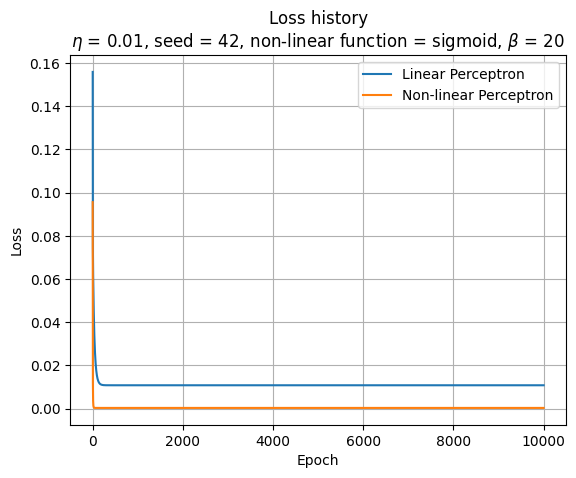

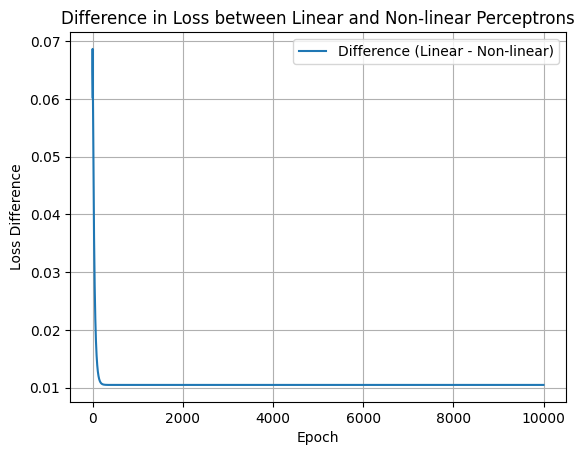

In [52]:
import matplotlib.pyplot as plt

# Calcular la diferencia de pérdida entre los dos modelos
loss_difference = [linear - non_linear for linear, non_linear in zip(perceptron_linear.loss_history, perceptron_non_linear.loss_history)]

# Graficar el historial de pérdidas de ambos modelos
plt.figure()

plt.plot(perceptron_linear.loss_history, label='Linear Perceptron')
plt.plot(perceptron_non_linear.loss_history, label='Non-linear Perceptron')

loss_string =(
  f'Loss history' + '\n'
  + f'$\\eta$ = {learning_rate}, seed = {seed}, non-linear function = {non_linear_fn}, $\\beta$ = {beta}'
)
plt.title(loss_string)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Graficar la diferencia de pérdidas
plt.figure()
plt.plot(loss_difference, label='Difference (Linear - Non-linear)')
plt.title('Difference in Loss between Linear and Non-linear Perceptrons')
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.legend()
plt.grid(True)
plt.show()


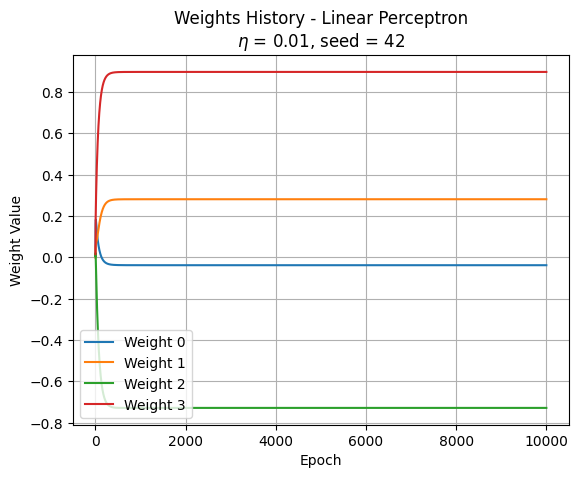

In [53]:
# Plot weights history for Linear Perceptron
plt.figure()
weights_linear = np.array(perceptron_linear.weights_history)
for i in range(weights_linear.shape[1]):
    plt.plot(weights_linear[:, i], label=f'Weight {i}')
wl_string =(
  f'Weights History - Linear Perceptron' + '\n'
  + f'$\\eta$ = {learning_rate}, seed = {seed}'
)
plt.title(wl_string)
plt.xlabel('Epoch')
plt.ylabel('Weight Value')
plt.legend()
plt.grid(True)
plt.show()

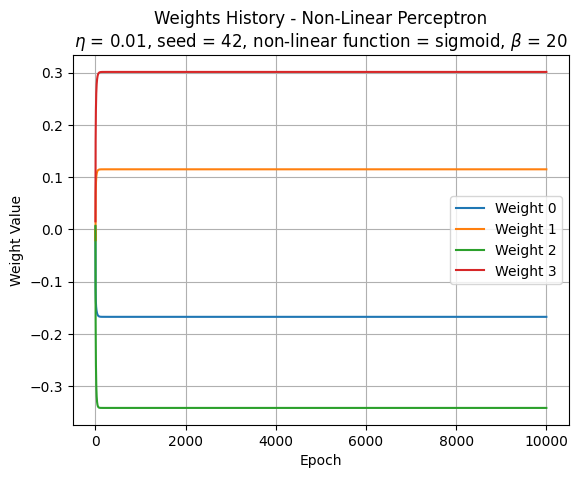

In [54]:
 # Plot weights history for Non-linear Perceptron
plt.figure()
weights_non_linear = np.array(perceptron_non_linear.weights_history)
for i in range(weights_non_linear.shape[1]):
    plt.plot(weights_non_linear[:, i], label=f'Weight {i}')

wnl_string =(
  f'Weights History - Non-Linear Perceptron' + '\n'
  + f'$\\eta$ = {learning_rate}, seed = {seed}, non-linear function = {non_linear_fn}, $\\beta$ = {beta}'
)
plt.title(wnl_string)

plt.xlabel('Epoch')
plt.ylabel('Weight Value')
plt.legend()
plt.grid(True)
plt.show()

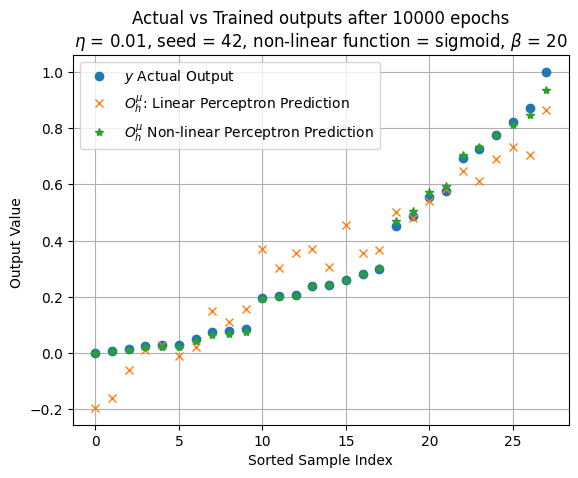

In [55]:
sorted_indices = np.argsort(y)


# Evaluate predictions on training data
y_pred_linear = perceptron_linear.predict(X_scaled_c)

# Predict on the training data (for non-linear)
y_pred_non_linear= perceptron_non_linear.predict(X_scaled_c)

y_ss = y_scaled_c[sorted_indices]
y_pred_linear_ss = y_pred_linear[sorted_indices]
y_pred_non_linear_ss = y_pred_non_linear[sorted_indices]

# Plot actual vs predicted outputs
plt.figure()
plt.plot(y_ss, 'o', label=r'$y$ Actual Output')
plt.plot(y_pred_linear_ss, 'x', label=r'$O^{\mu}_h$: Linear Perceptron Prediction')
plt.plot(y_pred_non_linear_ss, '*', label=r'$O^{\mu}_h$ Non-linear Perceptron Prediction')
avtr_string =(
  f'Actual vs Trained outputs after {num_epochs} epochs' + '\n'
  + f'$\\eta$ = {learning_rate}, seed = {seed}, non-linear function = {non_linear_fn}, $\\beta$ = {beta}'
)
plt.title(avtr_string)
plt.xlabel('Sorted Sample Index')
plt.ylabel(r'Output Value ')
plt.legend()
plt.grid(True)
plt.show()

#change this to show the actual ouptuts ordered from lowest to highest


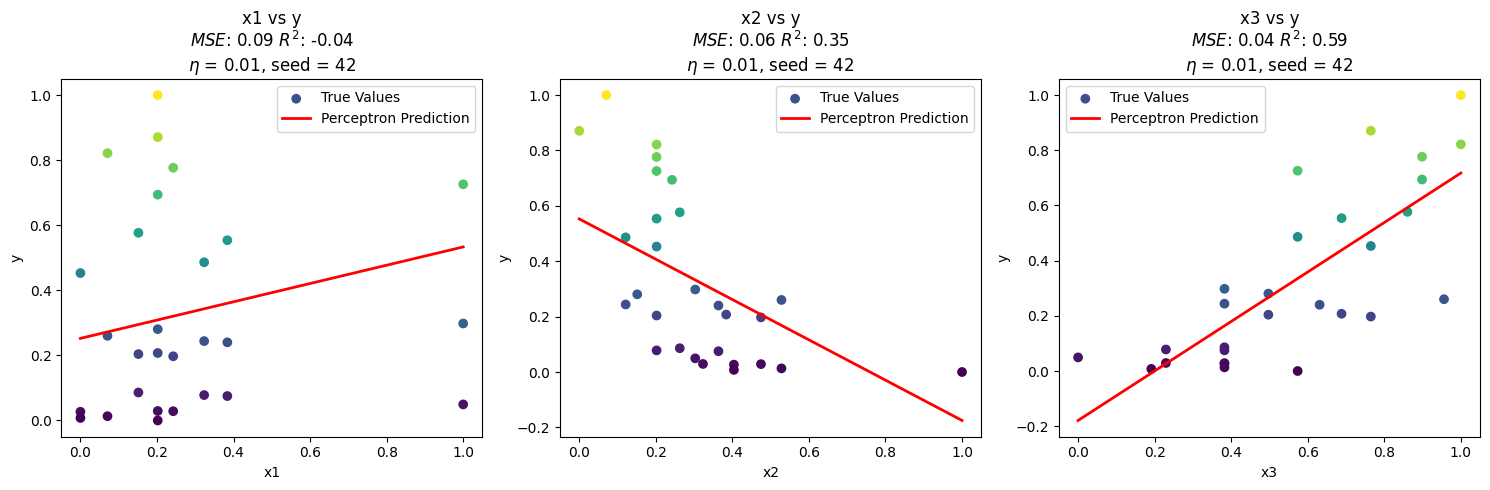

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Function to plot scatter and perceptron predictions with other features held at their mean
def plot_perceptron_feature(ax, x, y, xlabel, perceptron_model, num_features, X_full):
    # Scatter the actual data points
    ax.scatter(x, y, c=y, cmap='viridis', label='True Values')

    # Create a copy of the dataset and set the other features to their average values
    X_full_copy = np.mean(X_full, axis=0).reshape(1, -1)  # Start with the mean of all features
    X_full_copy = np.tile(X_full_copy, (x.shape[0], 1))   # Tile to the size of the input

    # Identify the column corresponding to the feature being plotted
    feature_index = int(xlabel[-1]) - 1
    X_full_copy[:, feature_index] = x  # Replace only the current feature with its varying values

    # Predict using the perceptron
    y_pred = perceptron_model.predict(X_full_copy)

    # Plot the model's predictions as a line
    sorted_x = np.sort(x)
    sorted_indices_x = np.argsort(x)
    y_pred_sorted = y_pred[sorted_indices_x]
    ax.plot(sorted_x, y_pred_sorted, color='red', linewidth=2, label='Perceptron Prediction')

    # Calculate R2 score
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel('y')
    title= (f'{xlabel} vs y\n$MSE$: {mse:.2f}' + f" $R^2$: {r2:.2f}" + '\n'
            + f'$\\eta$ = {learning_rate}, seed = {seed}')

    ax.set_title(title)
    ax.legend()

# Create a figure for plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Assuming df['x1'], df['x2'], df['x3'] are your features, and y is the target variable
# Pass the number of features your model was trained on (e.g., 3 if 3 features were used)
num_features = X.shape[1]

x1_scaled = X_scaled_c[:, 0]
x2_scaled = X_scaled_c[:, 1]
x3_scaled = X_scaled_c[:, 2]

# Plot x1 vs y using PerceptronLinear with other features held at their mean values
plot_perceptron_feature(axes[0], x1_scaled, y_scaled_c, 'x1', perceptron_linear, num_features, X_scaled_c)

# Plot x2 vs y using PerceptronLinear with other features held at their mean values
plot_perceptron_feature(axes[1], x2_scaled, y_scaled_c, 'x2', perceptron_linear, num_features, X_scaled_c)

# Plot x3 vs y using PerceptronLinear with other features held at their mean values
plot_perceptron_feature(axes[2], x3_scaled, y_scaled_c, 'x3', perceptron_linear, num_features, X_scaled_c)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


20


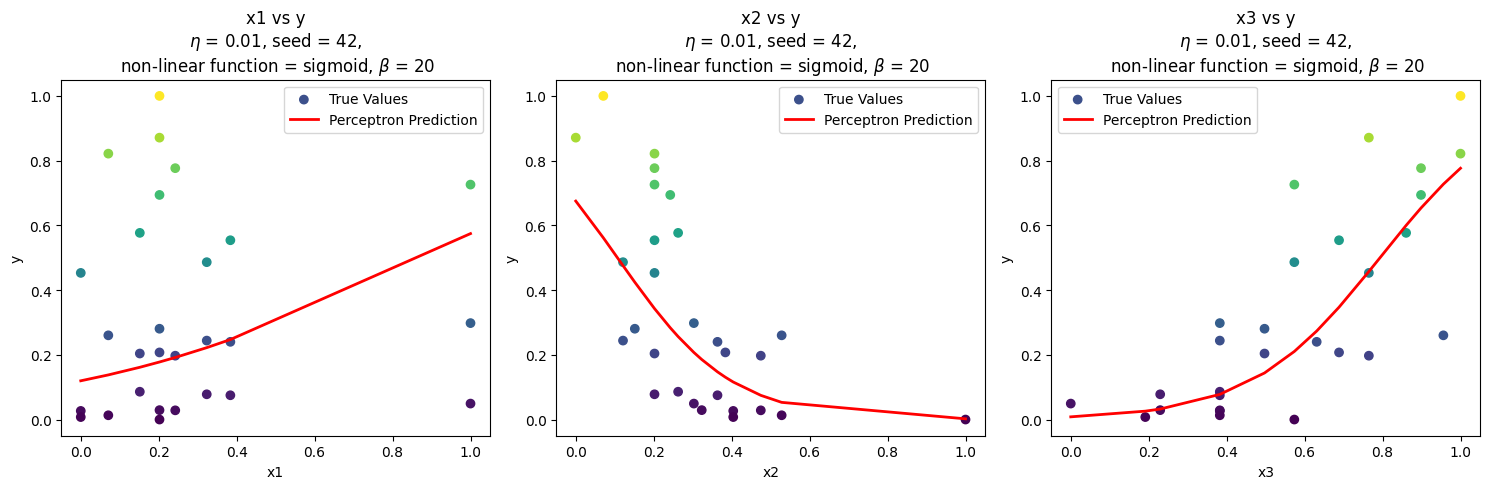

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
print(beta)
# Function to plot scatter and perceptron predictions with other features held at their mean
def plot_perceptron_feature(ax, x, y, xlabel, perceptron_model, num_features, X_full):
    # Scatter the actual data points
    ax.scatter(x, y, c=y, cmap='viridis', label='True Values')

    # Create a copy of the dataset and set the other features to their average values
    X_full_copy = np.mean(X_full, axis=0).reshape(1, -1)  # Start with the mean of all features
    X_full_copy = np.tile(X_full_copy, (x.shape[0], 1))   # Tile to the size of the input

    # Identify the column corresponding to the feature being plotted
    feature_index = int(xlabel[-1]) - 1
    X_full_copy[:, feature_index] = x  # Replace only the current feature with its varying values

    # Predict using the perceptron
    y_pred = perceptron_model.predict(X_full_copy)

    # Plot the model's predictions as a line
    sorted_x = np.sort(x)
    sorted_indices_x = np.argsort(x)
    y_pred_sorted = y_pred[sorted_indices_x]
    ax.plot(sorted_x, y_pred_sorted, color='red', linewidth=2, label='Perceptron Prediction')

    # Calculate R2 score
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel('y')
    title= (f'{xlabel} vs y' + '\n'
            + f'$\\eta$ = {learning_rate}, seed = {seed},' + '\n'
            + f' non-linear function = {non_linear_fn}, $\\beta$ = {beta}')

    ax.set_title(title)
    ax.legend()

# Create a figure for plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Assuming df['x1'], df['x2'], df['x3'] are your features, and y is the target variable
# Pass the number of features your model was trained on (e.g., 3 if 3 features were used)
num_features = X_scaled_c.shape[1]

x1_scaled = X_scaled_c[:, 0]
x2_scaled = X_scaled_c[:, 1]
x3_scaled = X_scaled_c[:, 2]

# Plot x1 vs y using PerceptronNonLinear with other features held at their mean values
plot_perceptron_feature(axes[0], x1_scaled, y_scaled_c, 'x1', perceptron_non_linear, num_features, X_scaled_c)

# Plot x2 vs y using PerceptronNonLinear with other features held at their mean values
plot_perceptron_feature(axes[1], x2_scaled, y_scaled_c, 'x2', perceptron_non_linear, num_features, X_scaled_c)

# Plot x3 vs y using PerceptronNonLinear with other features held at their mean values
plot_perceptron_feature(axes[2], x3_scaled, y_scaled_c, 'x3', perceptron_non_linear, num_features, X_scaled_c)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [58]:
# Generate configurations
activations = ['tanh', 'sigmoid', 'relu']
betas = [0.1, 0.5, 0.9, 1.0, 2.0, 5.0, 10.0]

perceptrons = []
for act in activations:
    if(act == 'relu'):
        perceptron = PerceptronNonLinear(
            seed=seed,
            num_features=X.shape[1],
            learning_rate=learning_rate,
            epsilon=epsilon,
            non_linear_fn=act
        )
        perceptrons.append(perceptron)
    else:
        for betax in betas:
            perceptrons.append(
                PerceptronNonLinear(
                    seed=seed,
                    num_features=X_scaled_c.shape[1] if act == 'sigmoid' else X_scaled_tanh.shape[1],
                    learning_rate=learning_rate,
                    epsilon=epsilon,
                    non_linear_fn=act,
                    beta=betax
                )
            )
# Train all perceptrons
# Train all perceptrons
for i, perceptron in enumerate(perceptrons):
    if perceptron.fn_name == 'sigmoid':
        perceptron.fit(X_scaled_logistic, y_scaled_c, num_epochs)
    elif perceptron.fn_name == 'tanh':
        perceptron.fit(X_scaled_tanh, y_scaled_tanh, num_epochs)
    else:
        perceptron.fit(X, y, num_epochs)

perceptrons_copy = perceptrons.copy()

Perceptron did not converge in 10000 epochs with error 0.01895585298078648
Perceptron did not converge in 10000 epochs with error 0.0009659189594941207
Perceptron did not converge in 10000 epochs with error 0.0009687352146420528
Perceptron did not converge in 10000 epochs with error 0.0009696906497354438
Perceptron did not converge in 10000 epochs with error 0.0009847369459548665
Perceptron did not converge in 10000 epochs with error 0.0010847562364871065
Perceptron did not converge in 10000 epochs with error 0.0033801027395640353
Perceptron did not converge in 10000 epochs with error 0.0725661115387091
Perceptron did not converge in 10000 epochs with error 0.005137344734895087
Perceptron did not converge in 10000 epochs with error 0.0006477305763635504
Perceptron did not converge in 10000 epochs with error 0.00045143970525777
Perceptron did not converge in 10000 epochs with error 0.00024167726244751558
Perceptron did not converge in 10000 epochs with error 0.00024414040378676027
Perce

In [59]:
# scael tanh back to normal
def inverse_scale_sigmoid(scaled_X):
    return scaler_X_sigmoid.inverse_transform(scaled_X)

def inverse_scale_tanh(scaled_X):
    return scaler_X_tanh.inverse_transform(scaled_X)


In [60]:
#perceptrons = perceptrons[:-1]

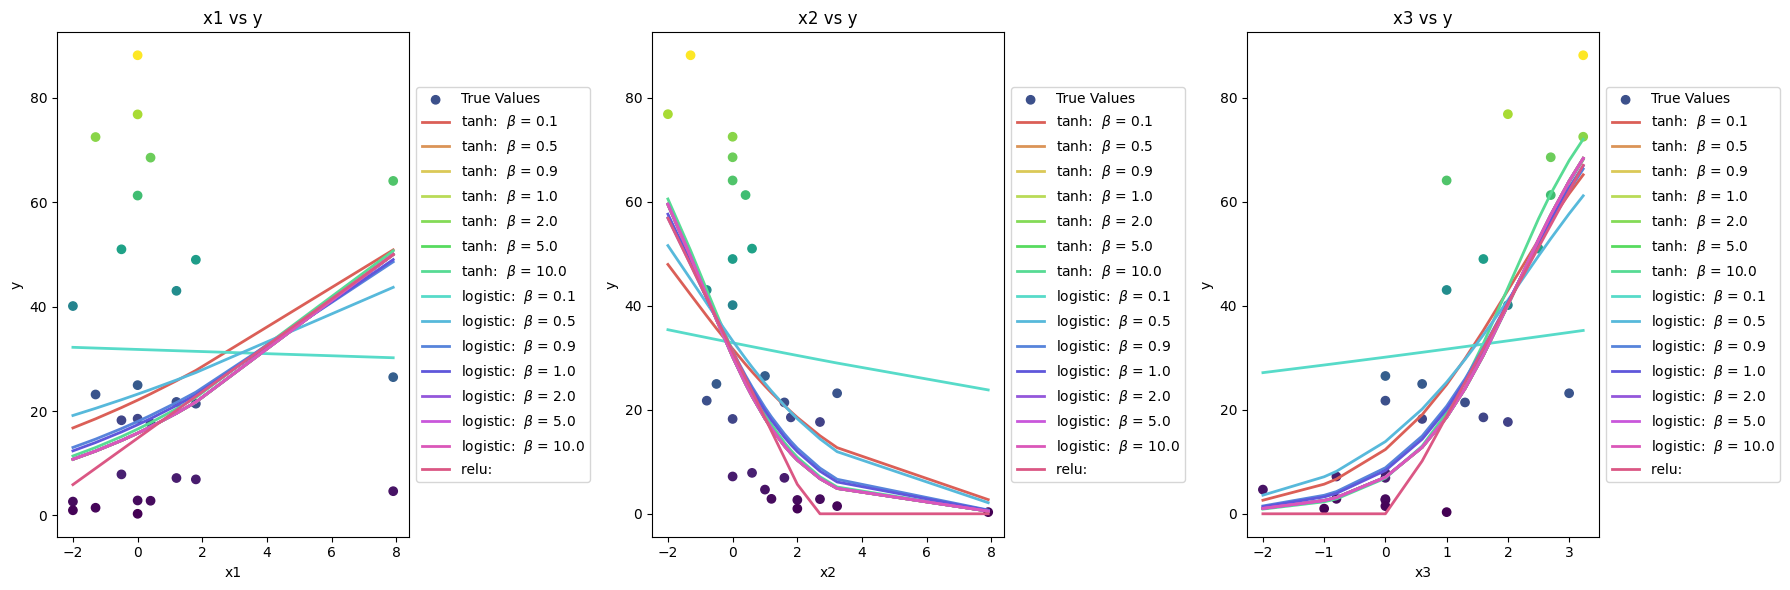

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # for a wider variety of colors

def plot_perceptron_feature(ax, x, y, xlabel, perceptrons, num_features, X_full):
    # Scatter the actual data points
    ax.scatter(x, y, c=y, cmap='viridis', label='True Values')

    # Prepare colors
    colors = sns.color_palette("hls", len(perceptrons))

    # Define labels based on your specifications
    labels = ['tanh'] * 7 + ['logistic'] * 7 + ['relu']

    for idx, (perceptron_model, color) in enumerate(zip(perceptrons, colors)):
        # Create a copy of the dataset and set the other features to their average values
        X_full_copy = np.mean(X_full, axis=0).reshape(1, -1)
        X_full_copy = np.tile(X_full_copy, (x.shape[0], 1))

        # Identify the column corresponding to the feature being plotted
        feature_index = int(xlabel[-1]) - 1
        X_full_copy[:, feature_index] = x

        # Apply the appropriate scaler depending on the perceptron type

        scaler = scaler_X_sigmoid if perceptron_model.fn_name == 'sigmoid'else scaler_X_tanh if perceptron_model.fn_name == 'tanh' else None

        if scaler is not None:
            X_full_copy = scaler.transform(X_full_copy)

        # Predict using the perceptron

        y_pred = perceptron_model.predict(X_full_copy)

        if scaler is not None:
            y_pred = y_pred.reshape(-1, 1)
            y_pred = scaler_y_sigmoid.inverse_transform(y_pred) if perceptron_model.fn_name == 'sigmoid' else scaler_y_tanh.inverse_transform(y_pred)
            # Ensure y_pred is reshaped correctly for inverse_transform

            # Apply inverse scaling to predictions

            # Flatten the predictions back to 1D
            y_pred = y_pred.flatten()

        # Plot the model's predictions
        sorted_x = np.sort(x)
        sorted_indices_x = np.argsort(x)
        y_pred = y_pred[sorted_indices_x]
        add_beta = f' $\\beta$ = {perceptron_model.beta}' if perceptron_model.fn_name != 'relu' else ''
        ax.plot(sorted_x, y_pred, color=color, linewidth=2, label=f'{labels[idx]}: {add_beta}')

    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel('y')
    ax.set_title(f'{xlabel} vs y')

    # Place the legend outside the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Create a figure for plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Assuming df['x1'], df['x2'], df['x3'] are your features, and y is the target variable
num_features = X.shape[1]

x1 = X[:, 0]
x2 = X[:, 1]
x3 = X[:, 2]

# Example list of trained perceptrons (replace with your actual list of perceptrons)

# Plot for each feature
plot_perceptron_feature(axes[0], x1, y, 'x1', perceptrons, num_features, X)
plot_perceptron_feature(axes[1], x2, y, 'x2', perceptrons, num_features, X)
plot_perceptron_feature(axes[2], x3, y, 'x3', perceptrons, num_features, X)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

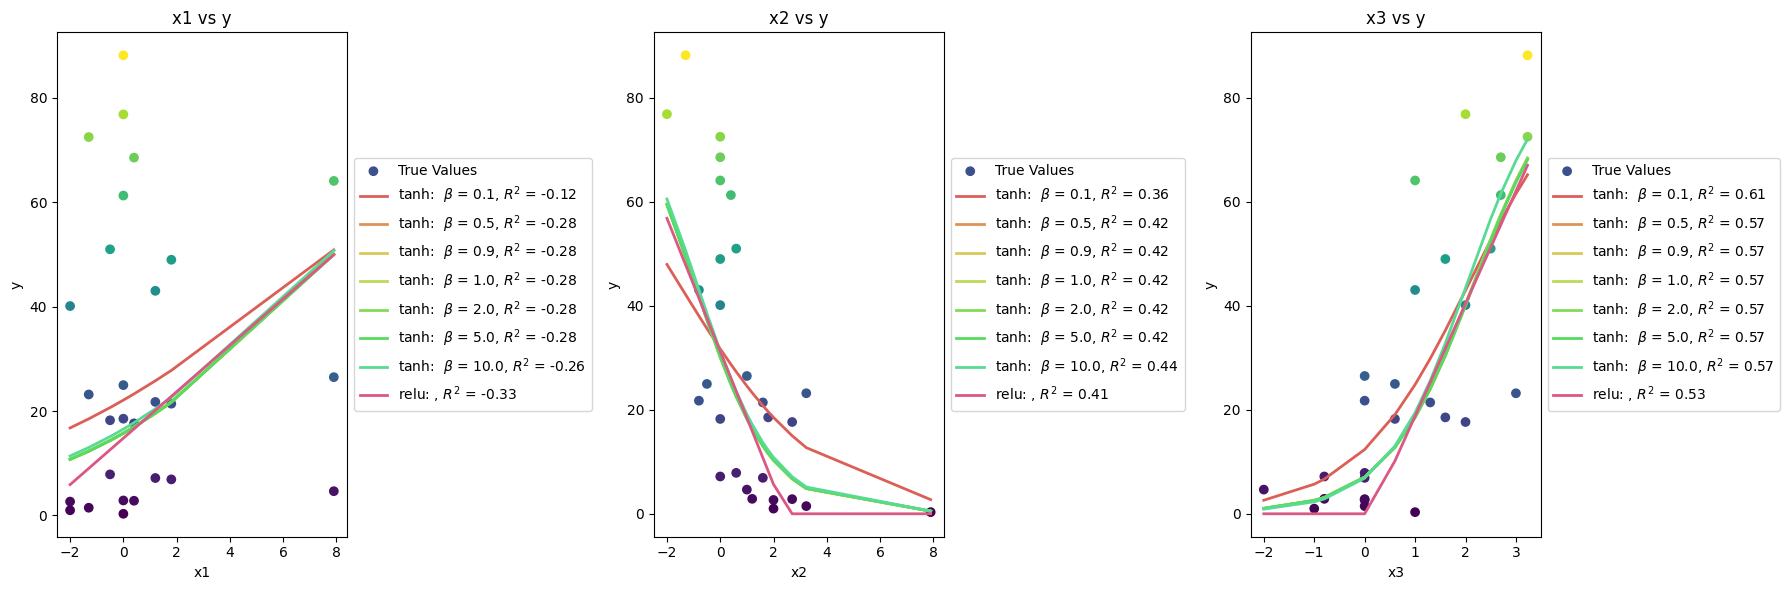

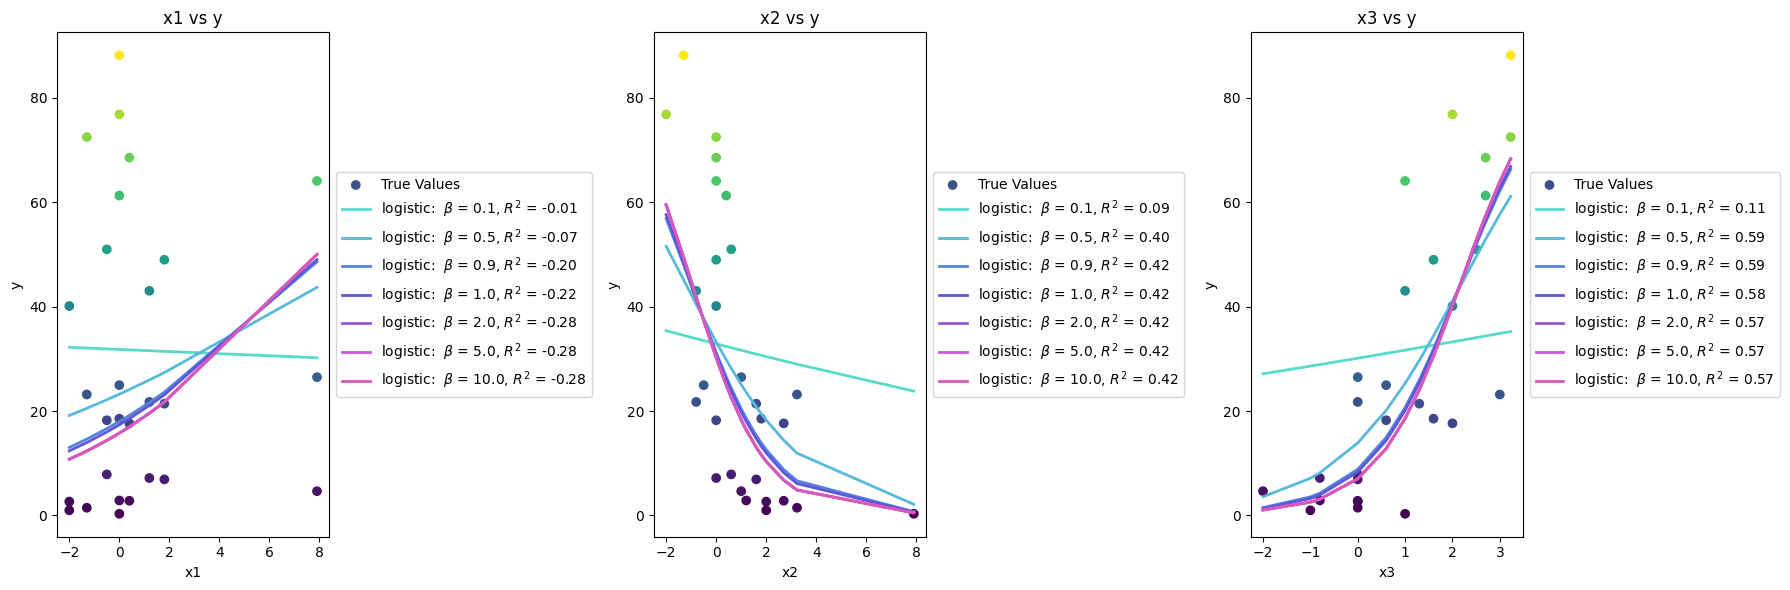

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # for a wider variety of colors
from sklearn.metrics import r2_score

def plot_perceptron_feature(ax, x, y, xlabel, perceptrons, num_features, X_full, filter_fn=None):
    # Scatter the actual data points
    ax.scatter(x, y, c=y, cmap='viridis', label='True Values')

    # Prepare colors
    colors = sns.color_palette("hls", len(perceptrons))

    # Define labels based on your specifications
    labels = ['tanh'] * 7 + ['logistic'] * 7 + ['relu']

    for idx, (perceptron_model, color) in enumerate(zip(perceptrons, colors)):
        if filter_fn and not filter_fn(perceptron_model):
            continue

        # Create a copy of the dataset and set the other features to their average values
        X_full_copy = np.mean(X_full, axis=0).reshape(1, -1)
        X_full_copy = np.tile(X_full_copy, (x.shape[0], 1))

        # Identify the column corresponding to the feature being plotted
        feature_index = int(xlabel[-1]) - 1
        X_full_copy[:, feature_index] = x

        # Apply the appropriate scaler depending on the perceptron type
        scaler = scaler_X_sigmoid if perceptron_model.fn_name == 'sigmoid' else scaler_X_tanh if perceptron_model.fn_name == 'tanh' else None

        if scaler is not None:
            X_full_copy = scaler.transform(X_full_copy)

        # Predict using the perceptron
        y_pred = perceptron_model.predict(X_full_copy)

        if scaler is not None:
            y_pred = y_pred.reshape(-1, 1)
            y_pred = scaler_y_sigmoid.inverse_transform(y_pred) if perceptron_model.fn_name == 'sigmoid' else scaler_y_tanh.inverse_transform(y_pred)
            y_pred = y_pred.flatten()

        # Calculate R^2 score
        r2 = r2_score(y, y_pred)

        # Plot the model's predictions
        sorted_x = np.sort(x)
        sorted_indices_x = np.argsort(x)
        y_pred = y_pred[sorted_indices_x]

        add_beta = f' $\\beta$ = {perceptron_model.beta}' if perceptron_model.fn_name != 'relu' else ''
        ax.plot(sorted_x, y_pred, color=color, linewidth=2, label=f'{labels[idx]}: {add_beta}, $R^2$ = {r2:.2f}')

    # Set labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel('y')
    ax.set_title(f'{xlabel} vs y')

    # Place the legend outside the plot
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Function to filter perceptrons based on the activation function
def filter_sigmoid(perceptron_model):
    return perceptron_model.fn_name == 'sigmoid'

def filter_tanh_relu(perceptron_model):
    return perceptron_model.fn_name in ['tanh', 'relu']

# Create a figure for plotting tanh and relu
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for tanh and relu models
plot_perceptron_feature(axes[0], X[:, 0], y, 'x1', perceptrons, num_features, X, filter_fn=filter_tanh_relu)
plot_perceptron_feature(axes[1], X[:, 1], y, 'x2', perceptrons, num_features, X, filter_fn=filter_tanh_relu)
plot_perceptron_feature(axes[2], X[:, 2], y, 'x3', perceptrons, num_features, X, filter_fn=filter_tanh_relu)

# Adjust layout and show the tanh and relu plot
plt.tight_layout()
plt.show()

# Create a second figure for plotting sigmoid
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for sigmoid models
plot_perceptron_feature(axes[0], X[:, 0], y, 'x1', perceptrons, num_features, X, filter_fn=filter_sigmoid)
plot_perceptron_feature(axes[1], X[:, 1], y, 'x2', perceptrons, num_features, X, filter_fn=filter_sigmoid)
plot_perceptron_feature(axes[2], X[:, 2], y, 'x3', perceptrons, num_features, X, filter_fn=filter_sigmoid)

# Adjust layout and show the sigmoid plot
plt.tight_layout()
plt.show()
